#Project 1: Gradient-based Algorithms and Differentiable Programming

###Problem formulation

In order to get a better realistic model, let us consider a simple rocket landing motion (vertical landing) considering drag,noise,gravity and thrust. We are also considering distribution of initial states rather than one.

Rocket state,$x(t)=\begin{bmatrix} d(t) \\ v(t) \end{bmatrix}$<br/>
Where,<br/>$t=$ time<br/> $d(t)=$ distance between rocket and the ground at time $t$<br/>
$v(t)=$ velocity of the rocket at time $t$<br/>
Discrete time dynamics,<br/>
$$d(t+1)=d(t)+v(t)\Delta t+w(t)$$<br/>
$$v(t+1)=v(t)+gravity(\Delta t)+(drag-thrust)a(t)\Delta t+u(t)$$<br/>
Where,<br/> $a(t)=$ acceleration of rocket at time $t$ . It is the control input of the rocket<br/>
$\Delta t =$time interval<br/>
$w(t)$ and $u(t)$ are noise<br/>
Closed loop controller,<br/>
$a(t)=f_{\theta}(x(t))$<br/>
Where,<br/>
$f_{\theta}(.)=$neural network with parameters $\theta$, which are to be determined through optimization <br/>
For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.<br/>
The optimization problem is now formulated as,<br/>
$\begin{aligned} \min_{\theta} \quad & \frac{1}{N} \sum_{i=1}^N||x^i(T)||^2 \\ \implies \min_{\theta} \quad & \frac{1}{N} \sum_{i=1}^N (d(T)^{(i)})^2 + (v(T)^{(i)})^2 \\ \quad & d(t+1)^{(i)}=d(t)^{(i)}+v(t)^{(i)}\Delta t+w(t)^{(i)} \\ \quad &v(t+1)^{(i)}=v(t)^{(i)}+gravity(\Delta t)+(drag-thrust)a(t)^{(i)}\Delta t+u(t)^{(i)},\\ \quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1 ,  i=1,....,N \end{aligned} $<br/><br/>
Variable and values assumed,<br/>
Time interval, $\Delta t = 1$ <br/>
$Gravity=9.81 / 1000 $ <br/>
$thrust=14.715 / 1000$<br/>
$drag=1/1000$<br/>
Final time, $T=20$<br/>
Number of samples,$N=20$<br/>


### Programming

In [1]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [33]:
FRAME_TIME = 1  # time interval
GRAVITY_ACCEL = 9.81/1000  # gravity constant
BOOST_ACCEL = 14.715/1000  # thrust constant
DRAG = 1/1000 #drag constant 
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """ 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])
        delta_state = (DRAG - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., -1.]) * action
        state = state + delta_state + delta_state_gravity
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)
        return state

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.plot(x, y)
        plt.show()

[1] loss: 1.073


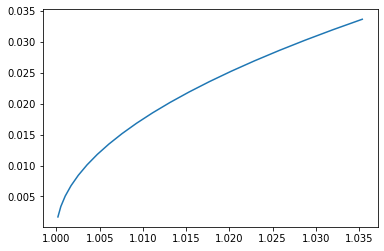

[2] loss: 1.073


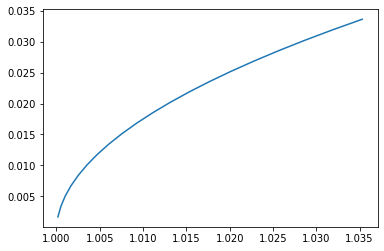

[3] loss: 1.073


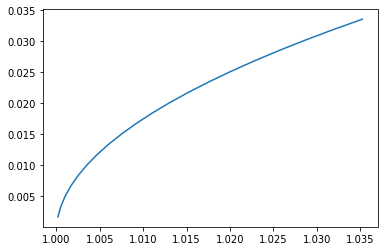

[4] loss: 1.073


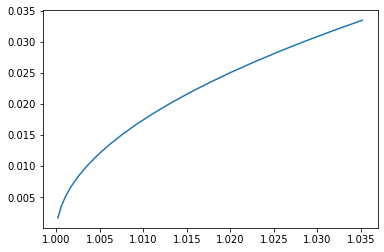

[5] loss: 1.073


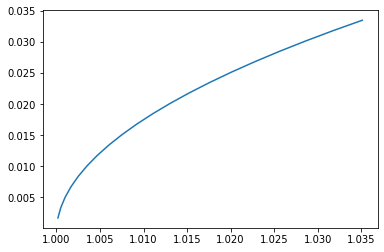

[6] loss: 1.072


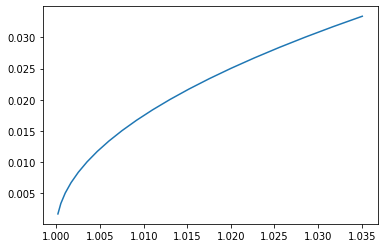

[7] loss: 1.072


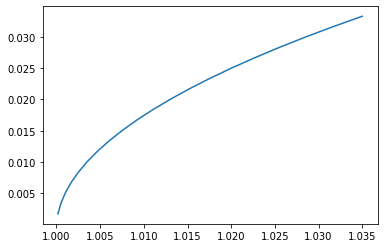

[8] loss: 1.072


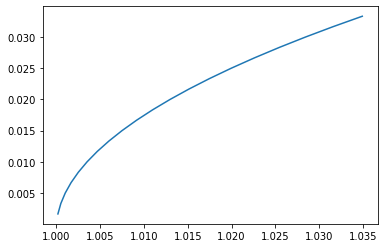

[9] loss: 1.072


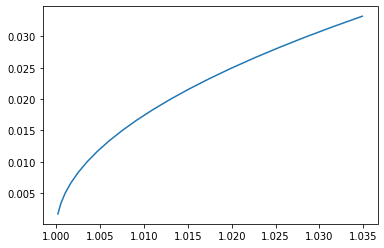

[10] loss: 1.072


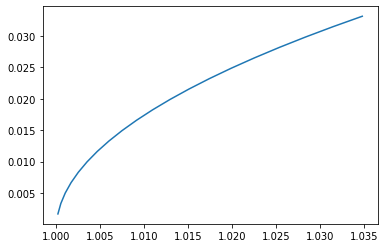

[11] loss: 1.072


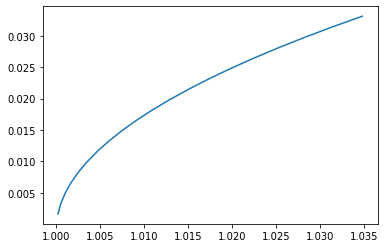

[12] loss: 1.072


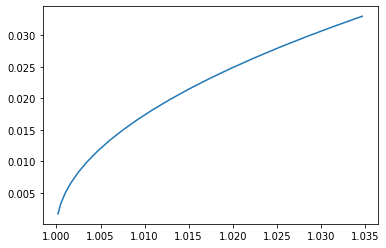

[13] loss: 1.072


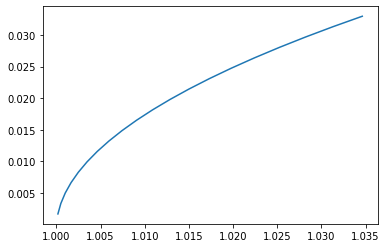

[14] loss: 1.071


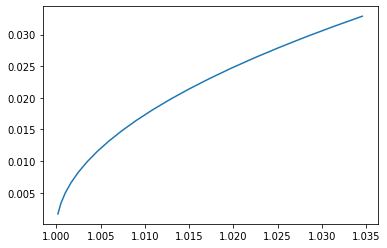

[15] loss: 1.071


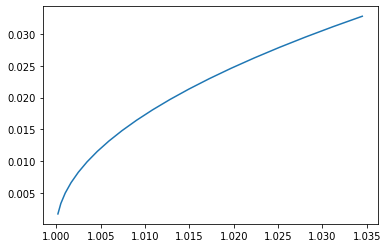

[16] loss: 1.071


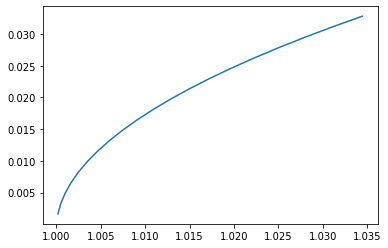

[17] loss: 1.071


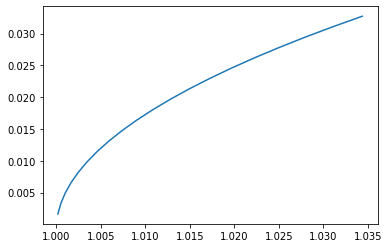

[18] loss: 1.071


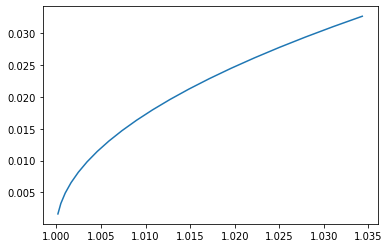

[19] loss: 1.052


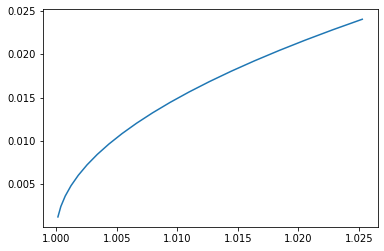

[20] loss: 1.048


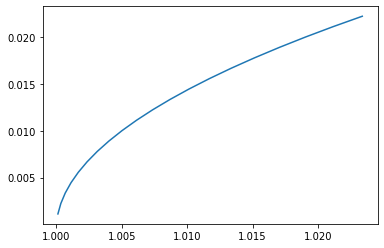

[21] loss: 1.046


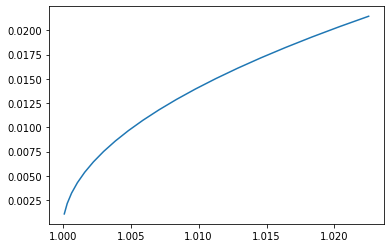

[22] loss: 1.045


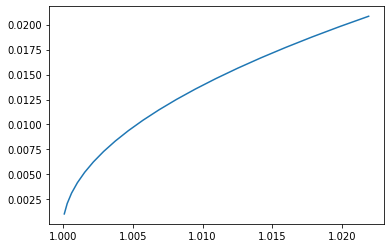

[23] loss: 1.044


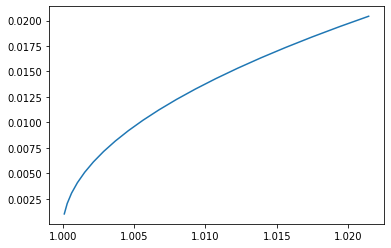

[24] loss: 1.043


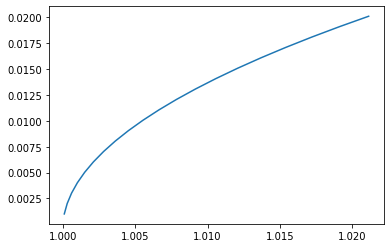

[25] loss: 1.043


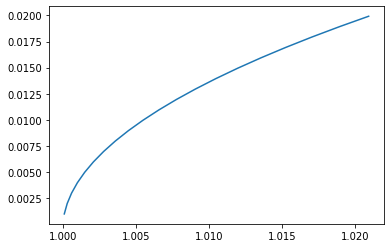

[26] loss: 1.042


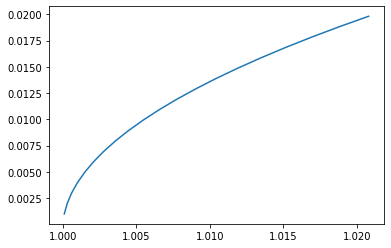

[27] loss: 1.042


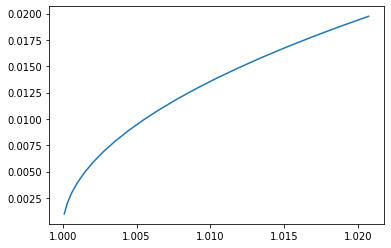

[28] loss: 1.042


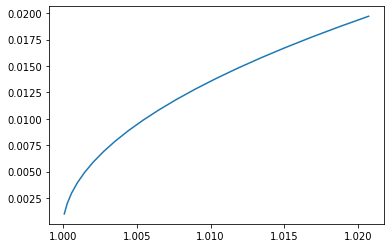

[29] loss: 1.042


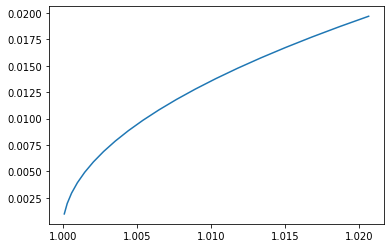

[30] loss: 1.042


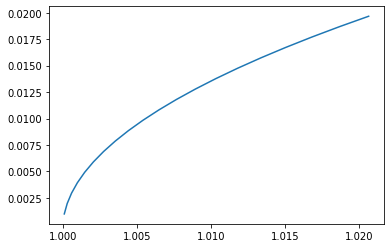

[31] loss: 1.042


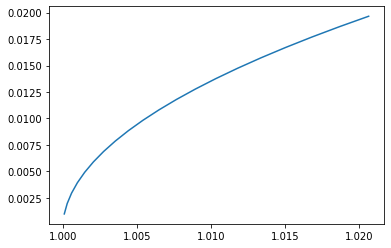

[32] loss: 1.042


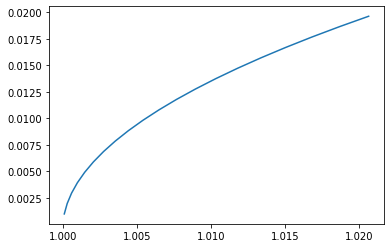

[33] loss: 1.042


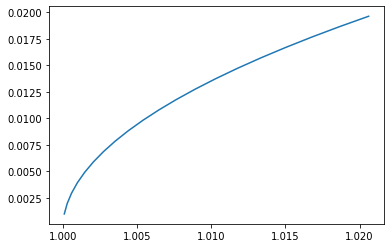

[34] loss: 1.042


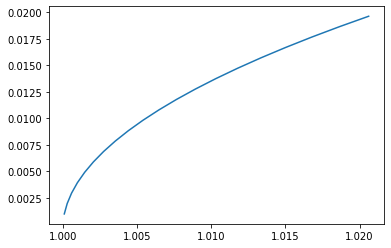

[35] loss: 1.042


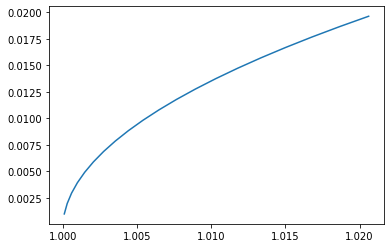

[36] loss: 1.042


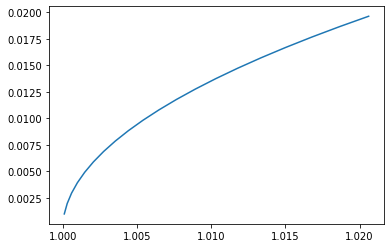

[37] loss: 1.042


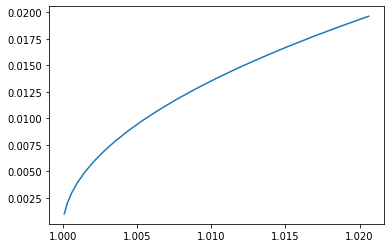

[38] loss: 1.042


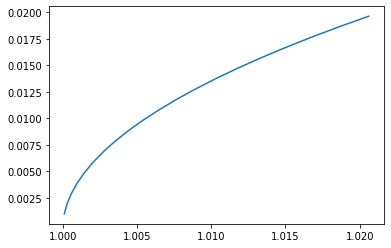

[39] loss: 1.042


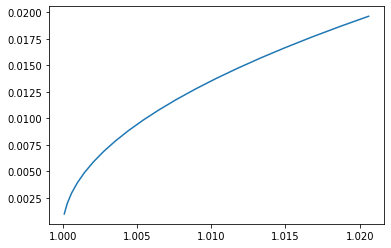

[40] loss: 1.042


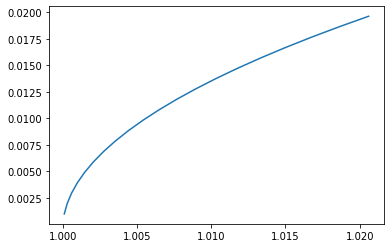

In [32]:
T = 20  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem